In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import mode
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})


1. Загрузка и EDA

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Описание датасета

Id - идентификационный номер квартиры 
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [3]:
df=pd.read_csv('train.csv',sep=',')
df=reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [4]:
test_df=pd.read_csv('test.csv',sep=',')
test_df=reduce_mem_usage(test_df)
test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [5]:
test_idx=test_df['Id']
test_idx.head()

0      725
1    15856
2     5480
3    15664
4    14275
Name: Id, dtype: int16

In [6]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [7]:
test_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

Приведение типов

In [8]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

In [9]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [10]:
df.dtypes

Id                 object
DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [11]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   object  
 1   DistrictId     5000 non-null   object  
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [14]:
df_cat_features=df.select_dtypes(include={'category','object'})
df_cat_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [15]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [18]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

Обзор количественных переменных

In [19]:
df_num_features=df.select_dtypes(include=['float32','int8','int16'])
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,2.0,47.981560,29.442751,6.0,7,9.0,0.089040,33,7976,5,NaN,0,11,184966.937500
1,3.0,65.683640,40.049541,8.0,7,9.0,0.000070,46,10309,1,240.0,1,16,300009.437500
2,2.0,44.947952,29.197611,0.0,8,12.0,0.049637,34,7759,0,229.0,1,3,220925.906250
3,2.0,53.352982,52.731510,9.0,8,17.0,0.437885,23,5735,3,1084.0,0,5,175616.234375
4,1.0,39.649193,23.776169,7.0,11,12.0,0.012339,35,5776,1,2078.0,2,4,150226.531250


Обработка пропусков

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [21]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Необходимо устранить пропуски в признаках LifeSquare, а Healthcare_1 удалим из-за большого кол-ва пропусков

In [22]:
medians=df['LifeSquare'].median()
medians

32.7812614440918

In [23]:
df['LifeSquare']=df['LifeSquare'].fillna(medians)
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Обработка выбросов

In [24]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,36.266048,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,76.609917,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Rooms 

In [25]:
#Есть квартиры, где кол-во комнат 0, нужно найти такие квартиры и заменить данные
median_Rooms=df['Rooms'].median()
df.loc[df['Rooms']<1,'Rooms']=df['Rooms'].median()
df['Rooms'].value_counts()

2.0     3888
1.0     3705
3.0     2235
4.0      150
5.0       18
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

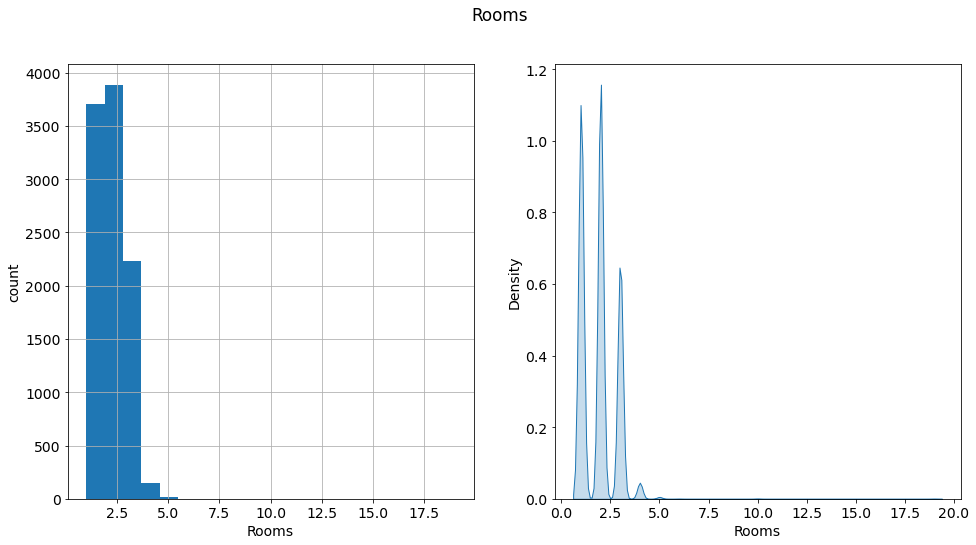

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(121)
df['Rooms'].hist(density=False,bins=20)
plt.xlabel('Rooms')
plt.ylabel('count')
plt.subplot(122)
sns.kdeplot(df['Rooms'],shade=True,legend=True)
plt.xlabel('Rooms')
plt.suptitle('Rooms')
plt.show()

In [27]:
# добавим новое условие, что более 6 комнат - это выброс

df.loc[df['Rooms']>6,'Rooms']=df['Rooms'].median()
df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

Square

In [28]:
#не может быть такого, чтобы общая площадь была меньше, чем сумма жилой и кухни
condition2=(df['Square']<(df['LifeSquare']+df['KitchenSquare']))
df[condition2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312
44,10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500
48,7596,23,1.0,47.080101,46.807991,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.164062
52,2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250
9910,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.500000
9918,14904,34,4.0,104.049133,99.788383,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,411971.093750
9961,1579,23,1.0,27.331108,32.781261,1.0,10,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60825.031250


In [29]:
df.loc[condition2,'Square']=df['Square'].median()
df.loc[condition2,'LifeSquare']=df['LifeSquare'].median()
df.loc[condition2,'KitchenSquare']=df['KitchenSquare'].median()

In [30]:
condition2=(df['Square']<(df['LifeSquare']+df['KitchenSquare']))
df[condition2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


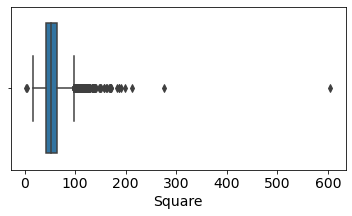

In [31]:
# Поищем выбросы по Square через boxplot
plt.figure(figsize=(6, 3))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [32]:
# сразу посмотрим и KitchenSquare и LifeSquare по выбросам
square=df[['Square','LifeSquare','KitchenSquare']]
square.head()

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,0.0
3,52.513309,32.781261,6.0
4,39.649193,23.776169,7.0


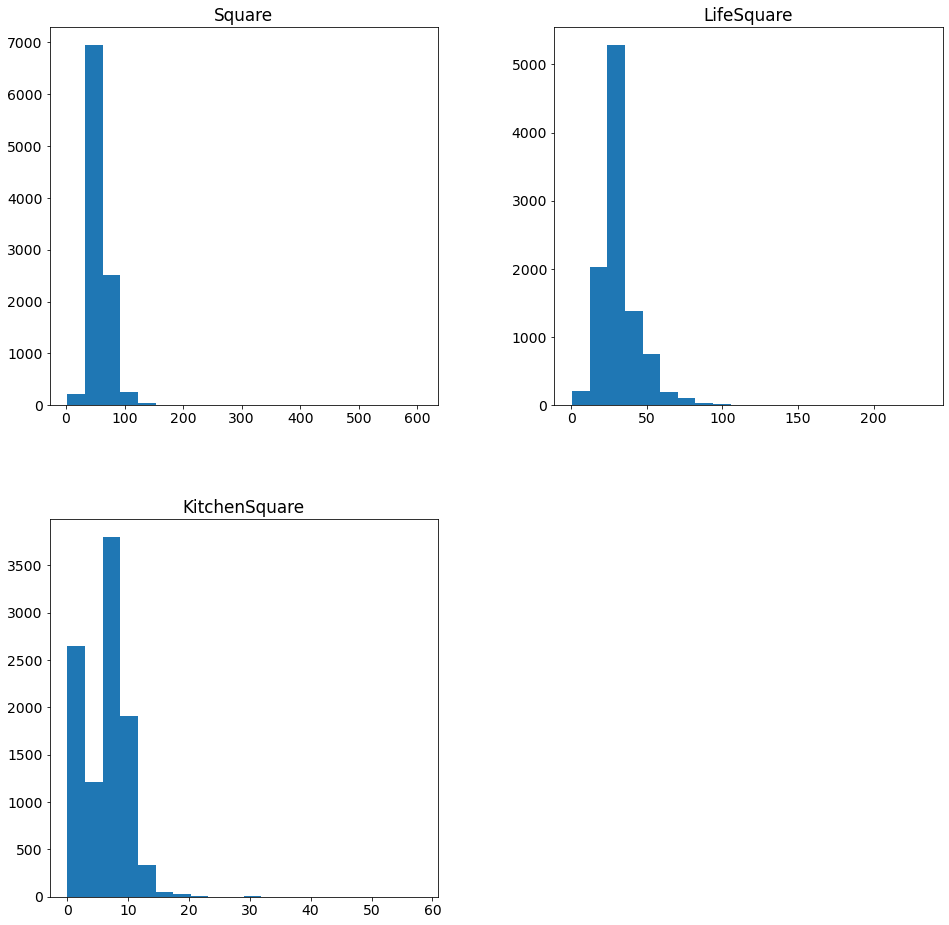

In [33]:
square.hist(figsize=(16,16), bins=20,grid=False);

In [34]:
square.describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,55.889050,33.223984,5.842000
std,18.710163,12.640908,3.743745
min,2.377248,0.370619,0.000000
25%,42.602382,25.728613,1.000000
50%,52.513309,32.781261,6.000000
75%,64.462358,35.320970,8.000000
max,604.705994,233.949310,58.000000


In [35]:
condition3=(df['Square']<20) | (df['Square']>150)
df.loc[condition3,'Square']=df['Square'].median()

In [36]:
condition4=(df['LifeSquare']<10) | (df['LifeSquare']>85)
df.loc[condition4,'LifeSquare']=df['LifeSquare'].median()

In [37]:
condition5=(df['KitchenSquare']<5) | (df['KitchenSquare']>20)
df.loc[condition5,'KitchenSquare']=df['KitchenSquare'].median()

In [38]:
square=df[['Square','LifeSquare','KitchenSquare']]

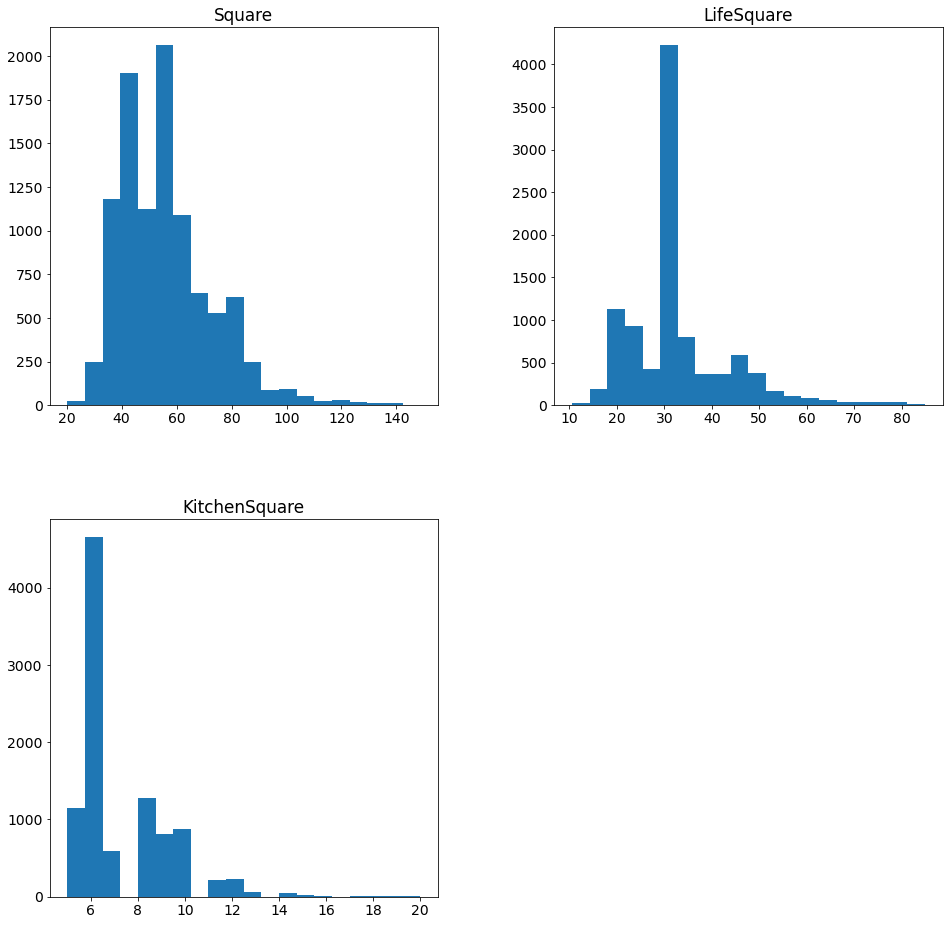

In [39]:
#обновленные данные по площадям
square.hist(figsize=(16,16), bins=20,grid=False);

Floor

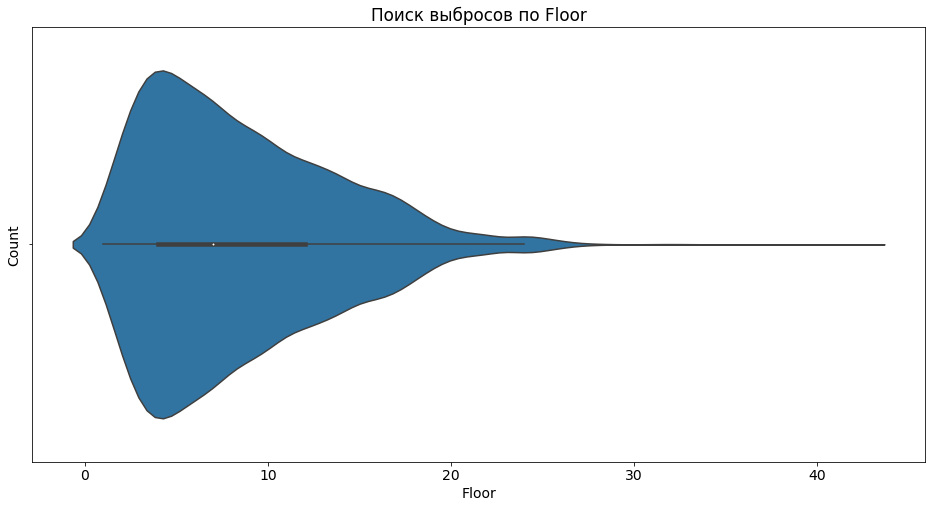

In [40]:
# Поиск выбросов по Floor
plt.figure(figsize=(16,8))
sns.violinplot(df['Floor'])
plt.xlabel('Floor')
plt.ylabel('Count')
plt.title('Поиск выбросов по Floor')
plt.show()

In [41]:
condition6=(df['Floor']>30) | (df['Floor']<1)
df.loc[condition6,'Floor']=df['Floor'].median()

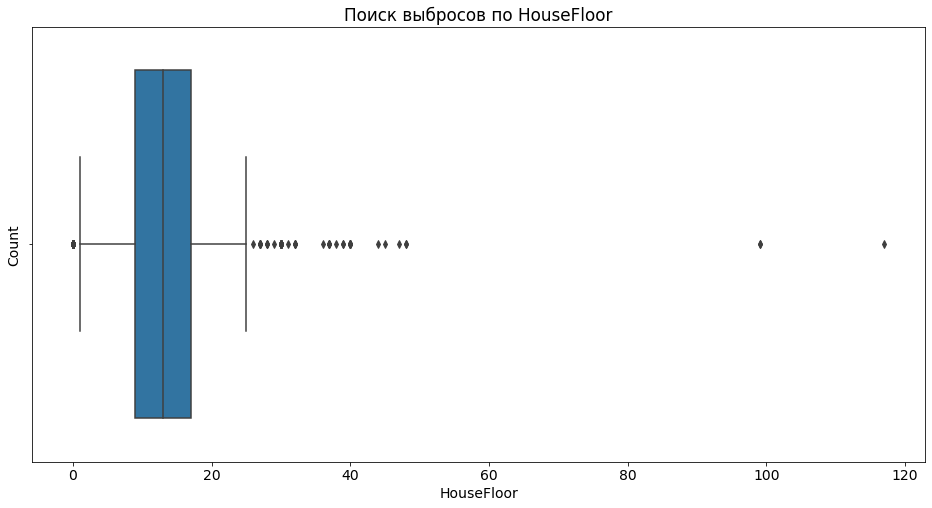

In [42]:
# Поиск выбросов по HouseFloor
plt.figure(figsize=(16,8))
sns.boxplot(df['HouseFloor'],whis=1)
plt.xlabel('HouseFloor')
plt.ylabel('Count')
plt.title('Поиск выбросов по HouseFloor')
plt.show()

In [43]:
condition7=(df['HouseFloor']>30) | (df['HouseFloor']<1)
df.loc[condition7,'HouseFloor']=df['HouseFloor'].median()

In [44]:
#не может быть такого, чтобы этаж квартиры был больше по значению,
#чем кол-во этажей в доме
condition8=df['Floor']>df['HouseFloor']
condition8.value_counts()

False    8379
True     1621
dtype: int64

In [45]:
condition8[9995]

True

In [46]:
df.loc[condition8,'Floor']=df['HouseFloor']

In [47]:
condition8=df['Floor']>df['HouseFloor']
condition8.value_counts()

False    10000
dtype: int64

In [48]:
df.loc[9995]

Id                        77
DistrictId                32
Rooms                    2.0
Square             50.401787
LifeSquare         30.476204
KitchenSquare            5.0
Floor                      5
HouseFloor               5.0
HouseYear               1968
Ecology_1            0.13565
Ecology_2                  B
Ecology_3                  B
Social_1                  46
Social_2                7960
Social_3                   6
Healthcare_1           350.0
Helthcare_2                3
Shops_1                   11
Shops_2                    B
Price            196684.3125
Name: 9995, dtype: object

In [49]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,52.513309,32.781261,6.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.0,5,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.939007,32.781261,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


ранее 9995 индекс выдавал True по условию, что этаж квартиры выше кол-ва этажей

HouseYear

In [50]:
#проверим есть ли выбросы по дате постройки дома
df[df['HouseYear']>2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


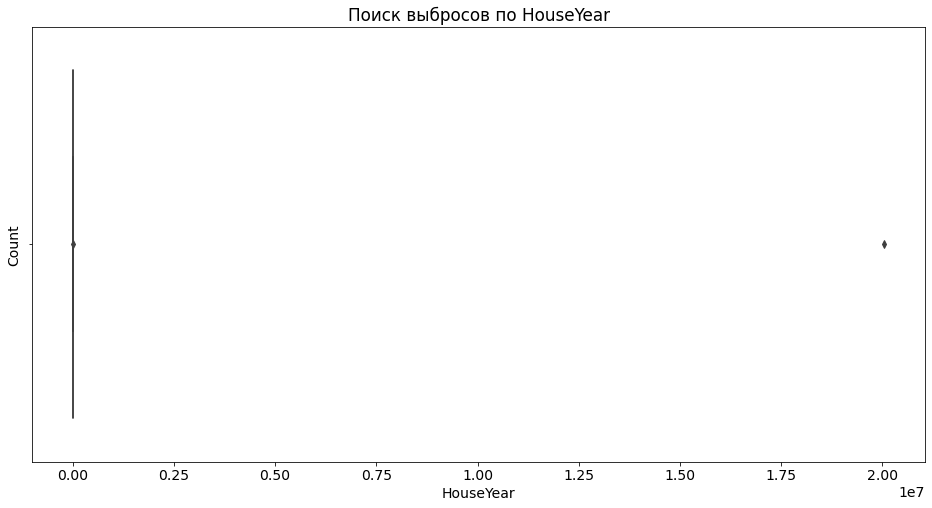

In [51]:
# Поиск выбросов по HouseYear
plt.figure(figsize=(16,8))
sns.boxplot(df['HouseYear'],whis=10)
plt.xlabel('HouseYear')
plt.ylabel('Count')
plt.title('Поиск выбросов по HouseYear')
plt.show()

In [52]:
# График неифнормативен, значит есть очень сильный выброс
condition9=df['HouseYear']>2020
df.loc[condition9,'HouseYear']=df['HouseYear'].median()
df['HouseYear'].describe()

count    10000.000000
mean      1984.863800
std         18.409979
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

In [53]:
df_num_features=df.select_dtypes(include=['float32','int16','int8','uint8','int32'])
df_num_features.drop('Price',axis=1, inplace =True)
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,2.0,52.513309,32.781261,6.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.0,5,5.0,1968,0.135650,46,7960,6,350.0,3,11
9996,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,30,5562,0,NaN,0,5
9997,1.0,47.939007,32.781261,6.0,12,16.0,2015,0.072158,2,629,1,NaN,0,0
9998,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,30,5048,9,325.0,2,5


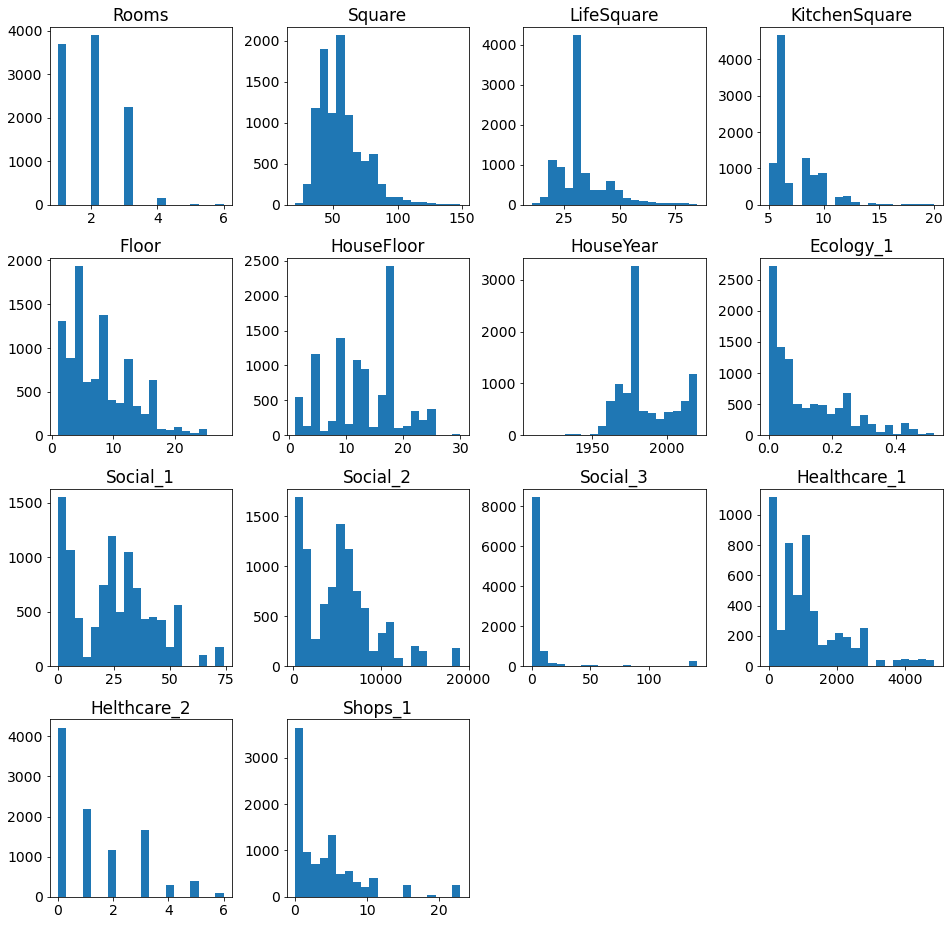

In [54]:
df_num_features.hist(figsize=(16,16),bins=20,grid=False);

Анализ целевой переменной

In [55]:
target_name='Price'

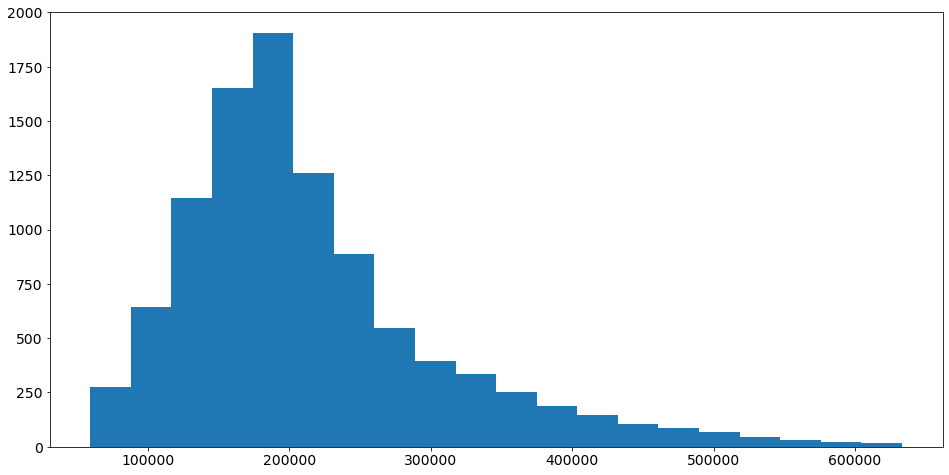

In [56]:
df['Price'].hist(figsize=(16,8),bins=20,grid=False);

In [57]:
target_mean=round(df['Price'].mean(),2)
target_median=df['Price'].median()
target_mode=df['Price'].mode()[0]

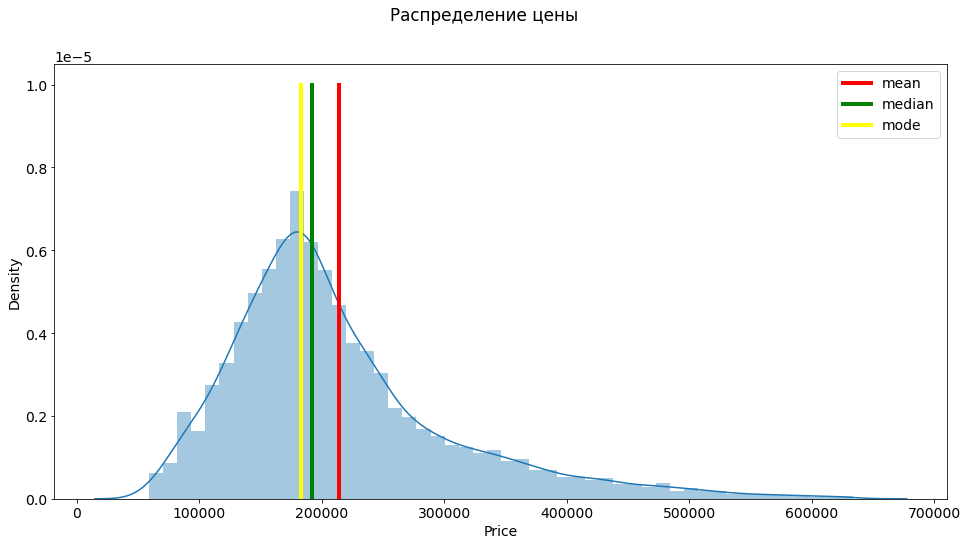

In [58]:
plt.figure(figsize=(16,8))
sns.distplot(df['Price'],bins=50)
y=np.linspace(0,0.000010,10)
plt.plot([target_mean]*10,y,label='mean',color='red', linewidth=4)
plt.plot([target_median]*10,y, label = 'median',color='green', linewidth=4)
plt.plot([target_mode]*10,y,label = 'mode', color='yellow', linewidth=4)
plt.suptitle('Распределение цены ')
plt.legend()
plt.show()

Генерация новых признаков

In [59]:
# Признак площадь комнаты (исходя из значения жилой площади LifeSquare)
df['Room_square']=(df['LifeSquare'])/(df['Rooms'])
df['Room_square']

0       14.721375
1       13.349847
2       14.598805
3       16.390631
4       23.776169
          ...    
9995    15.238102
9996    20.539215
9997    32.781261
9998    16.920074
9999    21.157875
Name: Room_square, Length: 10000, dtype: float32

In [60]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Room_square
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,14.721375
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,13.349847
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,14.598805
3,5809,58,2.0,52.513309,32.781261,6.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,16.390631
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,23.776169


In [61]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X,y=None):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
    def transform(self, X):
        """Трансформация данных"""

         #Обработка пропусков
        # LifeSquare 
        X[['LifeSquare']] = X[['LifeSquare']].fillna(self.medians)
        
        #Выбросы
        
        # Rooms
        X.loc[X['Rooms']<1,'Rooms']=self.medians['Rooms']
        X.loc[X['Rooms']>6,'Rooms']=self.medians['Rooms']
        
        #  Square
        condition2=(X['Square']<(X['LifeSquare']+X['KitchenSquare']))
        X.loc[condition2,'Square']=self.medians['Square']
        X.loc[condition2,'LifeSquare']=self.medians['LifeSquare']
        X.loc[condition2,'KitchenSquare']=self.medians['KitchenSquare']
        condition3=(X['Square']<20) | (X['Square']>150)
        X.loc[condition3,'Square']=self.medians['Square']
        
        # LifeSquare
        condition4=(X['LifeSquare']<10) | (X['LifeSquare']>85)
        X.loc[condition4,'LifeSquare']=self.medians['LifeSquare']
        
        # KitchenSquare
        condition5=(X['KitchenSquare']<5) | (X['KitchenSquare']>20)
        X.loc[condition5,'KitchenSquare']=self.medians['KitchenSquare']
        
      
        # HouseFloor, Floor
        condition6=(X['Floor']<1) | (X['Floor']>30)
        X.loc[condition6,'Floor']=self.medians['Floor']
        condition7=(X['HouseFloor']<1) | (X['HouseFloor']>30)
        X.loc[condition7,'HouseFloor']=self.medians['HouseFloor']
        condition8=X['Floor']>X['HouseFloor']
        X.loc[condition8,'Floor']=X['HouseFloor']
        
        # HouseYear
        condition9=X['HouseYear']>2020
        X.loc[condition9,'HouseYear']=self.medians['HouseYear']
        
        # Healthcare_1 - удалим из-за большого кол-ва пропусков
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
       
        # Генерация новых признаков
        
        X['Room_square']=(X['LifeSquare'])/(X['Rooms'])
        
        # Social_2
        if 'Social_2' in X.columns:
            X.drop('Social_2', axis=1, inplace=True)
        return X

Отбор признаков

In [62]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Room_square']

In [63]:

feature_names=[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1','Social_1', 'Social_2', 'Social_3',
                  'Helthcare_2', 'Shops_1','Room_square']
feature_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Room_square']

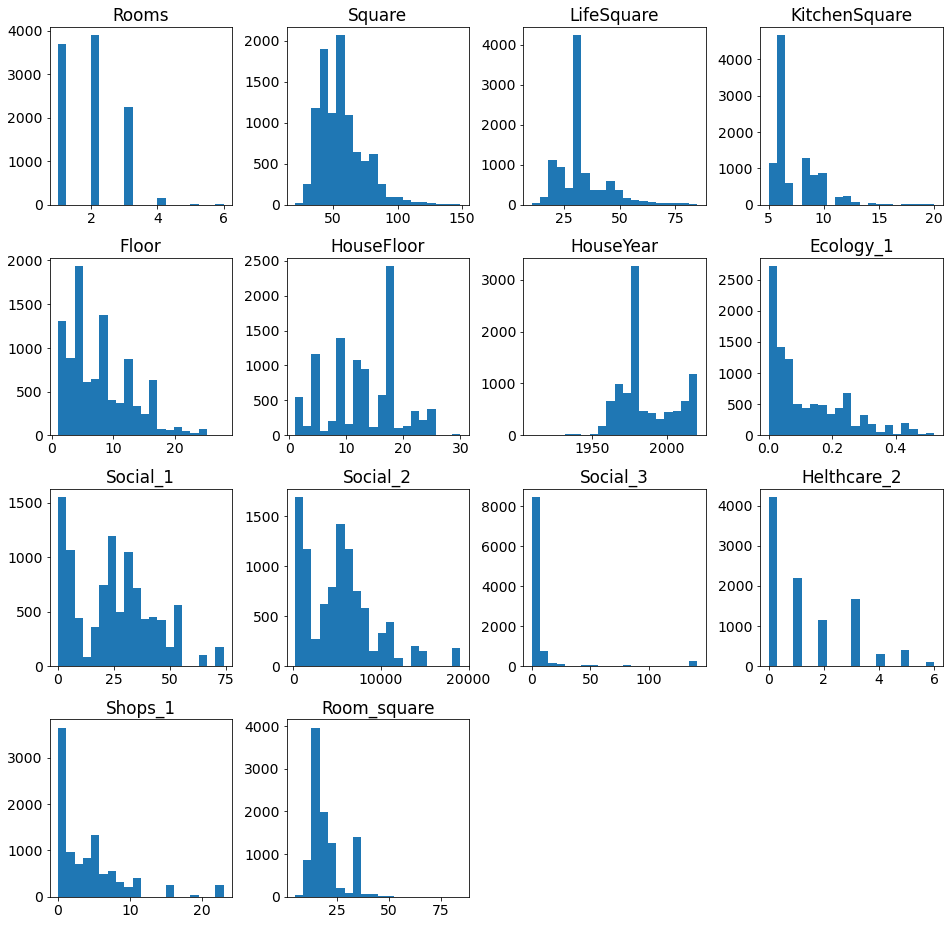

In [64]:
df[feature_names].hist(figsize=(16,16),bins=20,grid=False);

In [65]:
df=df[feature_names+[target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Room_square,Price
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,0,11,14.721375,184966.937500
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,1,16,13.349847,300009.437500
2,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,34,7759,0,1,3,14.598805,220925.906250
3,2.0,52.513309,32.781261,6.0,8,17.0,1977,0.437885,23,5735,3,0,5,16.390631,175616.234375
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2,4,23.776169,150226.531250


Сопоставление целевой переменной с другими признаками

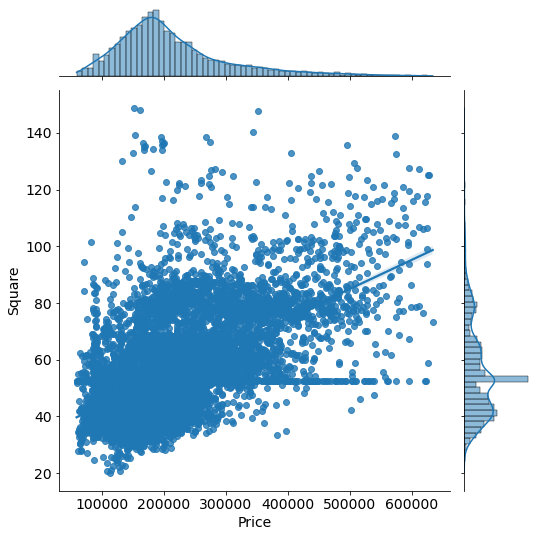

In [66]:
grid = sns.jointplot(df[target_name], df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

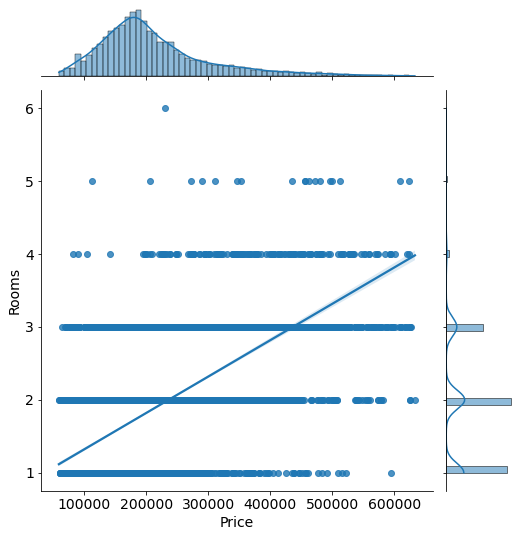

In [67]:
grid = sns.jointplot(df[target_name], df['Rooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

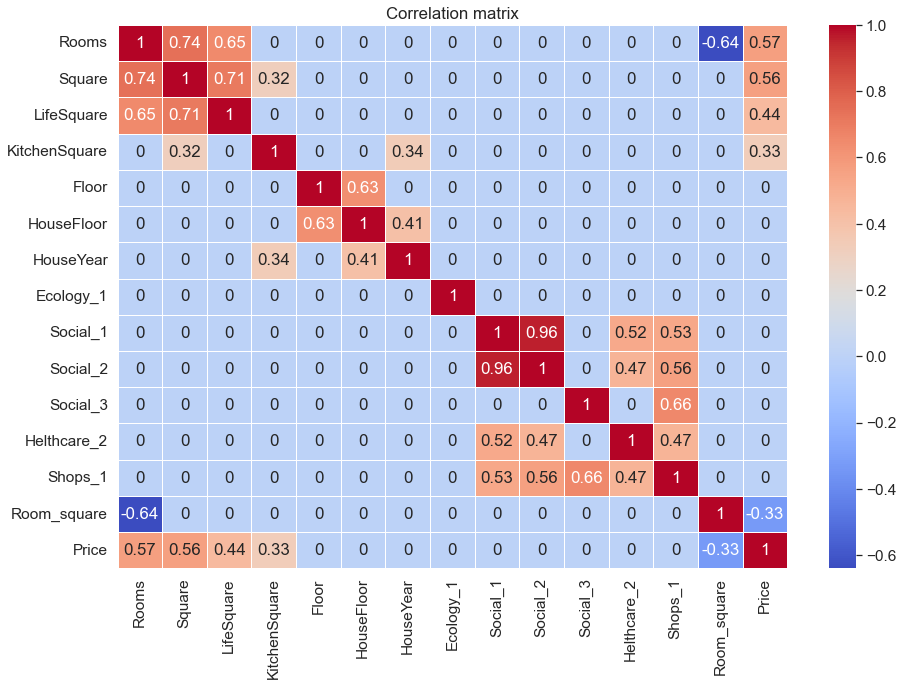

In [68]:
#Построим матрицу корреляций
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [69]:
# Нужно убрать либо Social_1 либо Social_2, т.к. они сильно коррелируют(0,96)
# и Shops_2,Ecology_2,Ecology_3 и HealthCare_1, т.к. там было слишком много пропусков
feature_names=[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1','Social_1', 'Social_3',
                'Helthcare_2', 'Shops_1','Room_square']
feature_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Room_square']

Сохранение датасета

In [70]:
import pickle 

In [71]:
df.to_csv('PREPARED_DOLGOPOLOVA_DATASET',index=False,encoding ='utf-8',sep=';')

Разбиение на train и test

In [72]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
X=df[feature_names]
y=df[target_name]
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.33,shuffle=True,random_state=42)

In [73]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [74]:
preprocessor = DataPreprocessing()
preprocessor.fit(df)
#preprocessor.fit(test_df)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 13), (3300, 13), (5000, 18))

In [75]:
df[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  float32
 1   Square         10000 non-null  float32
 2   LifeSquare     10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Social_1       10000 non-null  int8   
 9   Social_3       10000 non-null  int16  
 10  Helthcare_2    10000 non-null  int8   
 11  Shops_1        10000 non-null  int8   
 12  Room_square    10000 non-null  float32
dtypes: float32(7), int16(1), int32(1), int8(4)
memory usage: 371.2 KB


In [76]:
test_df[feature_names].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float32
 1   Square         5000 non-null   float32
 2   LifeSquare     5000 non-null   float32
 3   KitchenSquare  5000 non-null   float32
 4   Floor          5000 non-null   int8   
 5   HouseFloor     5000 non-null   float32
 6   HouseYear      5000 non-null   int16  
 7   Ecology_1      5000 non-null   float32
 8   Social_1       5000 non-null   int8   
 9   Social_3       5000 non-null   int16  
 10  Helthcare_2    5000 non-null   int8   
 11  Shops_1        5000 non-null   int8   
 12  Room_square    5000 non-null   float32
dtypes: float32(7), int16(2), int8(4)
memory usage: 175.9 KB


In [77]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Room_square
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.907800,55.967468,33.460526,7.163400,8.000600,12.810800,1984.392600,0.119874,24.933800,8.262600,1.31940,4.242800,19.531305
std,0.810093,17.171021,10.344739,2.033793,5.212642,6.105461,18.573149,0.120070,17.532202,23.863762,1.47994,4.777365,7.238470
min,1.000000,20.011215,10.692499,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.564166
25%,1.000000,42.952868,28.029077,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,0.000000,0.00000,1.000000,15.456230
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,2.000000,1.00000,3.000000,16.596603
75%,2.000000,64.888832,35.197519,8.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,5.000000,2.00000,6.000000,21.924318
max,6.000000,148.783493,83.194481,20.000000,26.000000,30.000000,2020.000000,0.521867,74.000000,141.000000,6.00000,23.000000,82.911308


In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

Построение модели. Модель GBRegressor показала лучший результат

GragientBoostingRegressor (уже по результатам GridSearchCv max_depth=7, n_estimators=100)

R2:	0.888
RMSE:	31093.838
MSE:	966826734.703


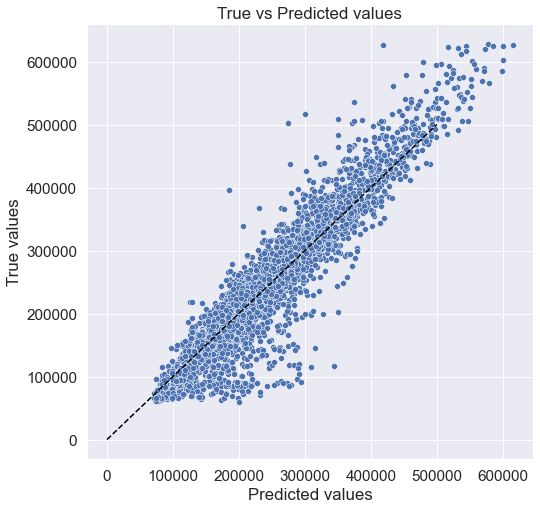

In [79]:
gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb.fit(X_train, y_train)

y_train_preds = gb.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.705
RMSE:	50410.257
MSE:	2541193977.596


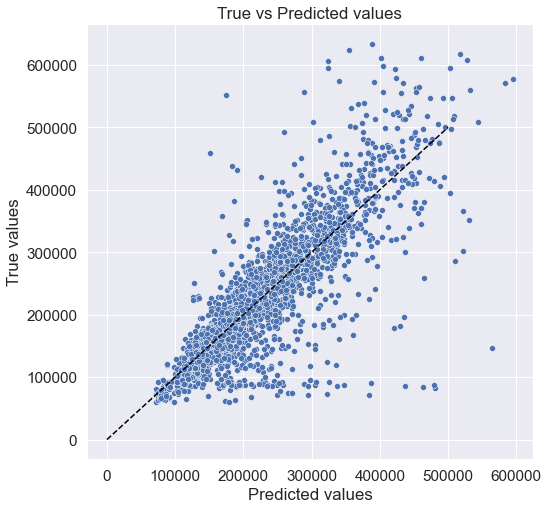

In [80]:
y_valid_preds=gb.predict(X_valid)
evaluate_preds(y_valid,y_valid_preds)

Важность признаков

In [81]:
gb.feature_importances_

array([0.09110847, 0.22260631, 0.23646241, 0.01527118, 0.01928631,
       0.02242449, 0.04531413, 0.06389139, 0.1109282 , 0.09758826,
       0.00779888, 0.03978343, 0.02753651])

In [82]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [83]:
feature_importances.head(3) # лучшие признаки

,feature_name,importance
2,LifeSquare,0.236462
1,Square,0.222606
8,Social_1,0.110928


In [84]:
feature_importances.tail(3) # худшие признаки

,feature_name,importance
4,Floor,0.019286
3,KitchenSquare,0.015271
10,Helthcare_2,0.007799


In [85]:
feature_importances.to_csv('REPORTS_FILE_PATH'+ 'feature_importances.csv', index=False)

In [86]:
feature_importances=feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature_name,importance
2,LifeSquare,0.236462
1,Square,0.222606
8,Social_1,0.110928
9,Social_3,0.097588
0,Rooms,0.091108
7,Ecology_1,0.063891
6,HouseYear,0.045314
11,Shops_1,0.039783
12,Room_square,0.027537
5,HouseFloor,0.022424


Применение модели на тесте

In [87]:
feature_names=[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1','Social_1', 'Social_3','Helthcare_2', 'Shops_1','Room_square']
feature_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Room_square']

In [88]:
y_test_preds = gb.predict(test_df[feature_names])

In [89]:
result = pd.DataFrame()
result=pd.DataFrame({'Id':test_idx, 'Price':pd.Series(y_test_preds)})

In [90]:
result.to_csv('prediction_by_test.csv', index=False)
result.values

array([[   725.        , 156842.56128503],
       [ 15856.        , 217469.42231261],
       [  5480.        , 351893.62875509],
       ...,
       [  5783.        , 334428.27128705],
       [  4780.        , 204544.44214098],
       [ 12504.        , 215587.12951581]])

In [91]:
data_test=pd.read_csv('prediction_by_test.csv')

In [92]:
data_test.head(10)

,Id,Price
0,725,156842.561285
1,15856,217469.422313
2,5480,351893.628755
3,15664,339355.463587
4,14275,132219.180516
5,7633,193108.458260
6,13329,162574.507842
7,5502,206430.530903
8,4220,265100.578674
9,11538,173123.936408


In [93]:
data_test['Price'].describe()

count      5000.000000
mean     215822.806124
std       78598.844220
min       71893.299678
25%      165870.471783
50%      195030.128997
75%      248238.180142
max      562888.289643
Name: Price, dtype: float64